<a href="https://colab.research.google.com/github/2003Yash/NLP-with-WebScarping/blob/main/Webscraping_and_NLP_and_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install feedparser pandas sqlalchemy huggingface_hub transformers

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.7 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=8c9716c9e827de99a91e140f504b34d3de88e63823b9ba10b1fa5bf3eaebbe52
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [ ]:
import feedparser
# feedparser is a Python library used to parse RSS and Atom feeds to parse ie., (extracting and interpreting)
# RSS (Really Simple Syndication) is a type of web feed that provides users with a simple way to get content updates from blogs, news websites, or other regularly updated sites.
import pandas as pd
from datetime import datetime

# Define RSS feed URLs ie.., these link has news article but in xml form
feeds = [
    "http://rss.cnn.com/rss/cnn_topstories.rss",
    "http://qz.com/feed",
    "http://feeds.foxnews.com/foxnews/politics",
    "http://feeds.reuters.com/reuters/businessNews",
    "http://feeds.feedburner.com/NewshourWorld",
    "https://feeds.bbci.co.uk/news/world/asia/india/rss.xml"
]

Web Scraping News Articles

In [ ]:
# Function to parse the RSS feeds and return a list of news articles
def parse_rss(feeds):
    articles = []
    for feed in feeds:
        parsed_feed = feedparser.parse(feed)
        for entry in parsed_feed.entries:
            articles.append({
                'title': entry.title,
                'link': entry.link,
                'pub_date': entry.get('published', datetime.now())
            })
    return articles

In [ ]:
# Scrape articles and store them in a CSV file
articles = parse_rss(feeds)
df = pd.DataFrame(articles)
df.to_csv('news_articles.csv', index=False)
print("Scraped articles have been saved to news_articles.csv")

Scraped articles have been saved to news_articles.csv


 Design a Database Schema to Store News Articles

In [ ]:
from sqlalchemy import create_engine, Column, Integer, String, DateTime, UniqueConstraint # sql alchemy converts sql sb into python objects to make work with python easily
# create_engine: This function is used to create a new SQLAlchemy engine instance, which manages connections to the database.
from sqlalchemy.ext.declarative import declarative_base
# declarative_base: A factory function that constructs a base class for declarative class definitions.
# creates a base class that your SQLAlchemy models inherit from. This allows you to define your database tables and their relationships using Python classes in a clear and concise way.
from sqlalchemy.orm import sessionmaker
# create session to establish connection between an application server and a database server to enable communication and data retrieval.
from datetime import datetime
 # library in Python handles dates and times, providing classes for manipulation, formatting, and arithmetic on date-time objects.


# Database setup
Base = declarative_base()
DATABASE_URL = "sqlite:///news_articles.db"
engine = create_engine(DATABASE_URL)
# Creates a database engine that will manage connections to the SQLite database specified in the DATABASE_URL
Session = sessionmaker(bind=engine)
# Binds a session factory to the engine, allowing you to create new sessions that will be used to interact with the database
session = Session() #  Instantiates a new session object, which is used to execute database operations

<ipython-input-6-67114b19f6ae>:7: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [ ]:
# we don't pair database url with table since we are creating the table inside the database url

# Define the NewsArticle schema
class NewsArticle(Base):
    __tablename__ = 'news_articles'

    id = Column(Integer, primary_key=True, autoincrement=True)
    title = Column(String, nullable=False)
    link = Column(String, nullable=False, unique=True)
    pub_date = Column(DateTime, nullable=True)
    added_date = Column(DateTime, default=datetime.utcnow)
    category = Column(String, nullable=True)  # For classification later

    __table_args__ = (UniqueConstraint('link', name='unique_link_constraint'),)
#  _table_arges_ = This is a special attribute used to specify additional constraints for the table. Here, a unique constraint is created for the link column to ensure that each link is unique.

Create the table

In [ ]:
Base.metadata.create_all(engine)

In [ ]:
# Function to add articles to the database without duplicates
def add_articles_to_db(articles):
  # create a list of all information from particles as articles and push articles into database.
    for article in articles:
        new_article = NewsArticle(
            title=article['title'],
            link=article['link'],
            pub_date=article['pub_date']
        )
        try:
            session.add(new_article) # Adds the new article instance to the current session.
            session.commit()  # Commits the changes to the database.
        except:
            session.rollback()  # Handle duplicates (existing link)

In [ ]:
# Insert articles into the database
add_articles_to_db(articles)
print("Articles have been stored in the database.")

Articles have been stored in the database.


Explicit Optional - Duplicacy check

In [ ]:
from sqlalchemy import func

# Function to remove duplicate articles based on the 'link'
def remove_duplicate_articles():
    # Find all duplicate links by counting occurrences
    duplicate_links = (
        session.query(NewsArticle.link)
        .group_by(NewsArticle.link)
        .having(func.count(NewsArticle.id) > 1)  # Find entries with more than 1 occurrence
        .all()
    )

    # Loop through each duplicate link
    for link, in duplicate_links:
        # Query all articles with the duplicate link
        duplicate_articles = session.query(NewsArticle).filter(NewsArticle.link == link).all()

        # Keep only the first article and delete the others
        for article in duplicate_articles[1:]:
            session.delete(article)

        # Commit the changes to the database
        session.commit()

    print(f"Removed {len(duplicate_links)} duplicate articles.")

# Call the function to remove duplicates
remove_duplicate_articles()

Removed 0 duplicate articles.


Print the Articles from the Database

In [ ]:
def print_all_articles():
    articles = session.query(NewsArticle).all()
    for article in articles:
        print(f"ID: {article.id}")
        print(f"Title: {article.title}")
        print(f"Link: {article.link}")
        print(f"Publication Date: {article.pub_date}")
        print(f"Added Date: {article.added_date}")
        print(f"Category: {article.category}")
        print("-" * 40)

# Print the articles stored in the database
print_all_articles()


ID: 1
Title: Dominion still has pending lawsuits against election deniers such as Rudy Giuliani and Sidney Powell
Link: https://www.cnn.com/business/live-news/fox-news-dominion-trial-04-18-23/h_8d51e3ae2714edaa0dace837305d03b8
Publication Date: 2024-10-12 14:25:39.221602
Added Date: 2024-10-12 14:44:33.113508
Category: None
----------------------------------------
ID: 2
Title: Russia is 'going backwards' in equipment and deploying post WWII-era tanks, according to Western officials
Link: https://www.cnn.com/europe/live-news/russia-ukraine-war-news-04-18-23/index.html
Publication Date: 2024-10-12 14:25:39.221682
Added Date: 2024-10-12 14:44:33.132322
Category: None
----------------------------------------
ID: 3
Title: Podcast: One country musician is calling for other artists to oppose assault rifles
Link: https://www.cnn.com/audio/podcasts/the-assignment/episodes/42a2f0e2-066a-4675-82ff-afe2016a0bb5
Publication Date: 2024-10-12 14:25:39.221758
Added Date: 2024-10-12 14:44:33.151332
Cat

Classify Articles Using Hugging Face LLMs

In [ ]:
from transformers import pipeline

# Load the Hugging Face model for text classification
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate labels for classification
labels = ["Terrorism / protest / political unrest / riot", "Positive/Uplifting", "Natural Disasters", "Others"]

# Function to classify and update the articles in the database
def classify_and_update_articles():
    articles = session.query(NewsArticle).all()
    for article in articles:
        # Use Hugging Face's zero-shot classification to classify the article
        result = classifier(article.title, labels)
        category = result['labels'][0]  # Select the top category

        # Update the article's category in the database
        article.category = category
        session.commit()
        print(f"Article '{article.title}' classified as {category}")

# Classify and update the articles
classify_and_update_articles()

# Print all articles with classification
print_all_articles()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Article 'Dominion still has pending lawsuits against election deniers such as Rudy Giuliani and Sidney Powell' classified as Positive/Uplifting
Article 'Russia is 'going backwards' in equipment and deploying post WWII-era tanks, according to Western officials' classified as Others
Article 'Podcast: One country musician is calling for other artists to oppose assault rifles' classified as Others
Article 'Bidets save you money and reduce waste — we tested the best options out there' classified as Positive/Uplifting
Article '50+ products to make your life easier and our planet cleaner' classified as Positive/Uplifting
Article 'Mother's Day is around the corner. Here are 50+ thoughtful gifts she'll love' classified as Positive/Uplifting
Article 'A head-to-toe guide of how men should dress this spring, and where they should shop' classified as Positive/Uplifting
Article '42 of the most useful travel products you can buy on Amazon' classified as Positive/Uplifting
Article 'The 7 best high-yie

Save Database as a CSV file

In [ ]:
import pandas as pd

# Function to export the news_articles table to a CSV file
def export_to_csv(file_name='news_articles_export.csv'):
    # Query all articles from the database
    articles = session.query(NewsArticle).all()

    # Convert the list of articles to a list of dictionaries
    data = []
    for article in articles:
        data.append({
            'id': article.id,
            'title': article.title,
            'link': article.link,
            'pub_date': article.pub_date,
            'added_date': article.added_date,
            'category': article.category
        })

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data)

    # Export the DataFrame to a CSV file
    df.to_csv(file_name, index=False)
    print(f"Database exported to {file_name}")

# Call the function to export the database to CSV
export_to_csv()


Database exported to news_articles_export.csv


Check for Distribution of classified articles

In [ ]:
import pandas as pd

df = pd.read_csv('news_articles_export.csv')
df.head()

,id,title,link,pub_date,added_date,category
0,1,Dominion still has pending lawsuits against el...,https://www.cnn.com/business/live-news/fox-new...,2024-10-12 14:25:39.221602,2024-10-12 14:44:33.113508,Positive/Uplifting
1,2,Russia is 'going backwards' in equipment and d...,https://www.cnn.com/europe/live-news/russia-uk...,2024-10-12 14:25:39.221682,2024-10-12 14:44:33.132322,Others
2,3,Podcast: One country musician is calling for o...,https://www.cnn.com/audio/podcasts/the-assignm...,2024-10-12 14:25:39.221758,2024-10-12 14:44:33.151332,Others
3,4,Bidets save you money and reduce waste — we te...,https://www.cnn.com/cnn-underscored/reviews/be...,2024-10-12 14:25:39.221811,2024-10-12 14:44:33.166110,Positive/Uplifting
4,5,50+ products to make your life easier and our ...,https://www.cnn.com/cnn-underscored/home/edito...,2024-10-12 14:25:39.221816,2024-10-12 14:44:33.175437,Positive/Uplifting


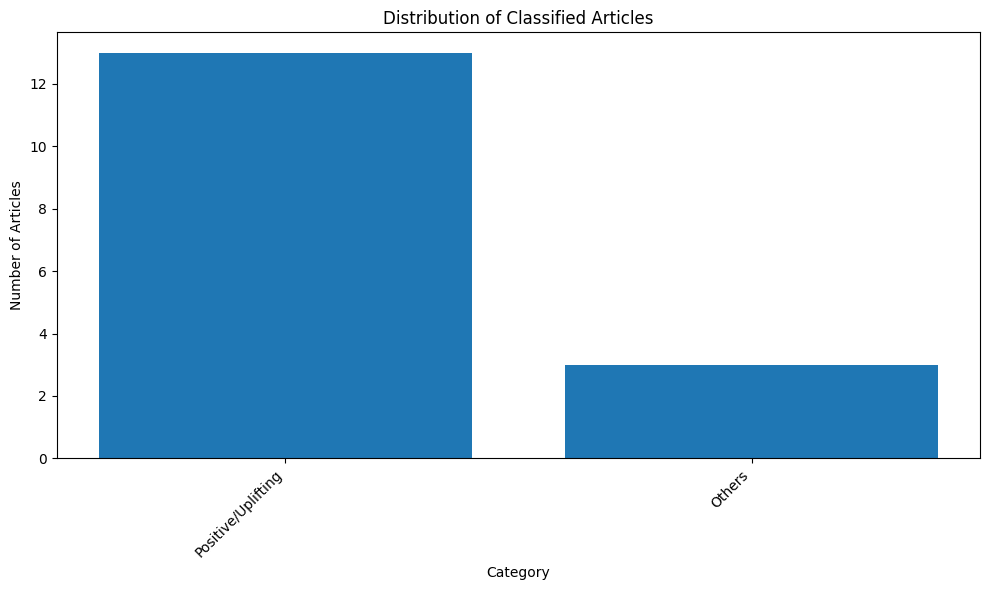

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the news articles
# and 'category' is the column with the classified categories

# Count the occurrences of each category
category_counts = df['category'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.title("Distribution of Classified Articles")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

CLASSIFCATION MANUALLY WITH KEYWORDS

In [ ]:
# Define the keywords for each category
keyword_dict = {
    "Terrorism": ["terror", "attack", "bomb", "militant", "terrorism"],
    "Protest": ["protest", "demonstration", "march", "rally"],
    "Political Unrest": ["political unrest", "civil unrest", "government", "regime", "election"],
    "Riot": ["riot", "violence", "clash", "mob"],
    "Positive/Uplifting": ["hope", "positive", "uplifting", "success", "good news"],
    "Natural Disasters": ["earthquake", "flood", "hurricane", "wildfire", "natural disaster"]
}

In [ ]:
# Function to classify the article based on keywords
def classify_article(title):
    # Convert the title to lowercase for case-insensitive matching
    title_lower = title.lower()

    # Check for keywords in the title and assign categories
    for category, keywords in keyword_dict.items():
        for keyword in keywords:
            if keyword in title_lower:
                return category

    # Default classification if no keywords match
    return "Others"

In [ ]:
# Apply the classification function to the DataFrame
df['manual_classification'] = df['title'].apply(classify_article)

# Print the updated DataFrame to see the classification results
print(df[['title', 'manual_classification']])

                                                title manual_classification
0   Dominion still has pending lawsuits against el...      Political Unrest
1   Russia is 'going backwards' in equipment and d...                Others
2   Podcast: One country musician is calling for o...                Others
3   Bidets save you money and reduce waste — we te...                Others
4   50+ products to make your life easier and our ...                Others
5   Mother's Day is around the corner. Here are 50...                Others
6   A head-to-toe guide of how men should dress th...                Others
7   42 of the most useful travel products you can ...                Others
8   The 7 best high-yield savings accounts of Apri...                Others
9   Taxes are due tomorrow. Here's how to file for...                Others
10  Composting is an easy way to reduce food waste...                Others
11  We stopped using aluminum foil for cooking and...                Others
12  The belo

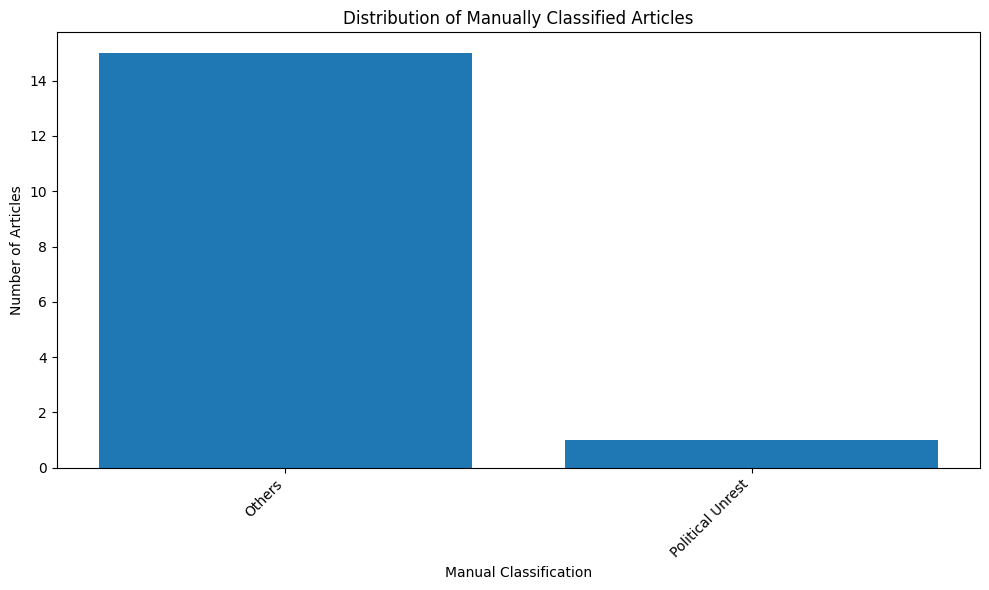

In [ ]:
# Count the occurrences of each manual classification
manual_classification_counts = df['manual_classification'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(manual_classification_counts.index, manual_classification_counts.values)
plt.xlabel("Manual Classification")
plt.ylabel("Number of Articles")
plt.title("Distribution of Manually Classified Articles")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# Optionally, save the updated DataFrame to a new CSV file
df.to_csv('news_articles_with_manual_classification.csv', index=False)
print("Updated CSV file saved as 'news_articles_with_manual_classification.csv'")

Updated CSV file saved as 'news_articles_with_manual_classification.csv'


# VERDICT: AFTER CHECKING UP THE DATABASE WE FOUND LLM APPROACH WORKS BEST EXCEPT FOR 0.0714% of SPECIAL CASES WHERE MANUAL KEYWORD CLASSIFICATION PROVED TO WORK BEST.